In [2]:
import os
import torch
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

# Define your directories
root_dir = os.path.expanduser("~")
audio_dir = "audio_twenty"
save_dir = "audio_twenty_models"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)


In [3]:
import os
import glob
import pandas as pd
# Scan the directory and prepare a list of all the audio file paths
audio_files = glob.glob(os.path.join(audio_dir, '**/*.wav'), recursive=True)

# Extract the class label from each file name or from the name of the parent sub-folder
# This assumes that your class labels are the names of the parent sub-folders
class_labels = [os.path.basename(os.path.dirname(file)) for file in audio_files]

# Map each class name from text to a numeric class ID
# This creates a dictionary where the keys are your class labels and the values are unique integers
class_dict = {label: idx for idx, label in enumerate(set(class_labels))}
class_ids = [class_dict[label] for label in class_labels]
class_names = list(class_dict.keys())
# Extract the file name and its parent folder name from each audio file path
relative_paths = [os.path.join(os.path.basename(os.path.dirname(file)), os.path.basename(file)) for file in audio_files]

# Create a DataFrame
df = pd.DataFrame({
    'relative_path': relative_paths,
    'classID': class_ids
})

df.head(100)


,relative_path,classID
0,aam\aam_01.wav,12
1,aam\aam_02.wav,12
2,aam\aam_03.wav,12
3,aam\aam_04.wav,12
4,aam\aam_05.wav,12
...,...,...
95,aat\aat_mahim.wav,8
96,aat\aat_masum.wav,8
97,aat\aat_ramim.wav,8
98,aat\aat_riaz.wav,8


In [4]:
num_classes = df['classID'].nunique()
print(f'There are {num_classes} unique classes in the DataFrame.')
class_names

There are 20 unique classes in the DataFrame.


['gach',
 'sahajjo',
 'abhawa',
 'dukkhito',
 'baari',
 'amar',
 'baba',
 'amader',
 'aat',
 'agun',
 'maa',
 'aangti',
 'aam',
 'akash',
 'ador',
 'poribar',
 'valobasha',
 'dhonnobad',
 'bondhu',
 'alo']

In [4]:
import math, random
import torch
import torchaudio
from torchaudio import transforms
from IPython.display import Audio

class AudioUtil():
  # ----------------------------
  # Load an audio file. Return the signal as a tensor and the sample rate
  # ----------------------------
  @staticmethod
  def open(audio_file):
    sig, sr = torchaudio.load(audio_file)
    return (sig, sr)
  # Convert the given audio to the desired number of channels
  # ----------------------------
  @staticmethod
  def rechannel(aud, new_channel):
    sig, sr = aud

    if (sig.shape[0] == new_channel):
      # Nothing to do
      return aud

    if (new_channel == 1):
      # Convert from stereo to mono by selecting only the first channel
      resig = sig[:1, :]
    else:
      # Convert from mono to stereo by duplicating the first channel
      resig = torch.cat([sig, sig])

    return ((resig, sr))

      # Since Resample applies to a single channel, we resample one channel at a time
  # ----------------------------
  @staticmethod
  def resample(aud, newsr):
    sig, sr = aud

    if (sr == newsr):
      # Nothing to do
      return aud

    num_channels = sig.shape[0]
    # Resample first channel
    resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
    if (num_channels > 1):
      # Resample the second channel and merge both channels
      retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
      resig = torch.cat([resig, retwo])

    return ((resig, newsr))

    # Pad (or truncate) the signal to a fixed length 'max_ms' in milliseconds
  # ----------------------------
  @staticmethod
  def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)

    return (sig, sr)

      # Shifts the signal to the left or right by some percent. Values at the end
  # are 'wrapped around' to the start of the transformed signal.
  # ----------------------------
  @staticmethod
  def time_shift(aud, shift_limit):
    sig,sr = aud
    _, sig_len = sig.shape
    shift_amt = int(random.random() * shift_limit * sig_len)
    return (sig.roll(shift_amt), sr)

      # ----------------------------
  # Generate a Spectrogram
  # ----------------------------
  @staticmethod
  def spectro_gram(aud, n_mels=64, n_fft=1024, hop_len=None):
    sig,sr = aud
    top_db = 80

    # spec has shape [channel, n_mels, time], where channel is mono, stereo etc
    spec = transforms.MelSpectrogram(sr, n_fft=n_fft, hop_length=hop_len, n_mels=n_mels)(sig)

    # Convert to decibels
    spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
    return (spec)

     # Augment the Spectrogram by masking out some sections of it in both the frequency
  # dimension (ie. horizontal bars) and the time dimension (vertical bars) to prevent
  # overfitting and to help the model generalise better. The masked sections are
  # replaced with the mean value.
  # ----------------------------
  @staticmethod
  def spectro_augment(spec, max_mask_pct=0.1, n_freq_masks=1, n_time_masks=1):
    _, n_mels, n_steps = spec.shape
    mask_value = spec.mean()
    aug_spec = spec

    freq_mask_param = max_mask_pct * n_mels
    for _ in range(n_freq_masks):
      aug_spec = transforms.FrequencyMasking(freq_mask_param)(aug_spec, mask_value)

    time_mask_param = max_mask_pct * n_steps
    for _ in range(n_time_masks):
      aug_spec = transforms.TimeMasking(time_mask_param)(aug_spec, mask_value)

    return aug_spec

In [5]:

from torch.utils.data import DataLoader, Dataset, random_split
import torchaudio

# ----------------------------
# Sound Dataset
# ----------------------------
class SoundDS(Dataset):
  def __init__(self, df, data_path):
    self.df = df
    self.data_path = str(data_path)
    self.duration = 4000
    self.sr = 44100
    self.channel = 2
    self.shift_pct = 0.4

  # ----------------------------
  # Number of items in dataset
  # ----------------------------
  def __len__(self):
    return len(self.df)

  # ----------------------------
  # Get i'th item in dataset
  # ----------------------------
  def __getitem__(self, idx):
    # Absolute file path of the audio file - concatenate the audio directory with
    # the relative path
    audio_file = self.data_path + self.df.loc[idx, 'relative_path']
    # Get the Class ID
    class_id = self.df.loc[idx, 'classID']

    aud = AudioUtil.open(audio_file)
    # Some sounds have a higher sample rate, or fewer channels compared to the
    # majority. So make all sounds have the same number of channels and same
    # sample rate. Unless the sample rate is the same, the pad_trunc will still
    # result in arrays of different lengths, even though the sound duration is
    # the same.
    reaud = AudioUtil.resample(aud, self.sr)
    rechan = AudioUtil.rechannel(reaud, self.channel)

    dur_aud = AudioUtil.pad_trunc(rechan, self.duration)
    shift_aud = AudioUtil.time_shift(dur_aud, self.shift_pct)
    sgram = AudioUtil.spectro_gram(shift_aud, n_mels=64, n_fft=1024, hop_len=None)
    aug_sgram = AudioUtil.spectro_augment(sgram, max_mask_pct=0.1, n_freq_masks=2, n_time_masks=2)

    return aug_sgram, class_id

In [6]:
from torch.utils.data import random_split

# Define your audio directory
data_path = os.path.join(os.path.expanduser("~"), "Desktop", "cse499b", "audio_twenty/")

myds = SoundDS(df, data_path)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=64, shuffle=False)


In [7]:
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn

# ----------------------------
# Audio Classification Model
# ----------------------------
class AudioClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block
        self.conv1 = nn.Conv2d(2, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Fifth Convolution Block
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)
        init.kaiming_normal_(self.conv5.weight, a=0.1)
        self.conv5.bias.data.zero_()
        conv_layers += [self.conv5, self.relu5, self.bn5]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=128, out_features=20)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)

    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x



# Create the model and put it on the GPU if available
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)
# Check that it is on Cuda
next(myModel.parameters()).device

device(type='cpu')

Epoch 1/500, Train Loss: 3.0254, Train Acc: 0.0334, Val Loss: 3.0314, Val Acc: 0.0581
Epoch Duration: 35.43 seconds
Epoch 2/500, Train Loss: 3.0112, Train Acc: 0.0407, Val Loss: 3.0237, Val Acc: 0.0349
Epoch Duration: 32.02 seconds
Epoch 3/500, Train Loss: 2.9845, Train Acc: 0.0625, Val Loss: 2.9780, Val Acc: 0.0291
Epoch Duration: 24.94 seconds
Epoch 4/500, Train Loss: 2.9788, Train Acc: 0.0625, Val Loss: 2.9954, Val Acc: 0.0814
Epoch Duration: 19.16 seconds
Epoch 5/500, Train Loss: 2.9738, Train Acc: 0.0727, Val Loss: 2.9816, Val Acc: 0.0640
Epoch Duration: 25.54 seconds
Epoch 6/500, Train Loss: 2.9622, Train Acc: 0.0625, Val Loss: 2.9840, Val Acc: 0.0756
Epoch Duration: 19.78 seconds
Epoch 7/500, Train Loss: 2.9437, Train Acc: 0.0828, Val Loss: 2.9812, Val Acc: 0.0756
Epoch Duration: 23.43 seconds
Epoch 8/500, Train Loss: 2.9390, Train Acc: 0.1061, Val Loss: 2.9762, Val Acc: 0.0640
Epoch Duration: 26.93 seconds
Epoch 9/500, Train Loss: 2.9298, Train Acc: 0.0916, Val Loss: 2.9595, Va

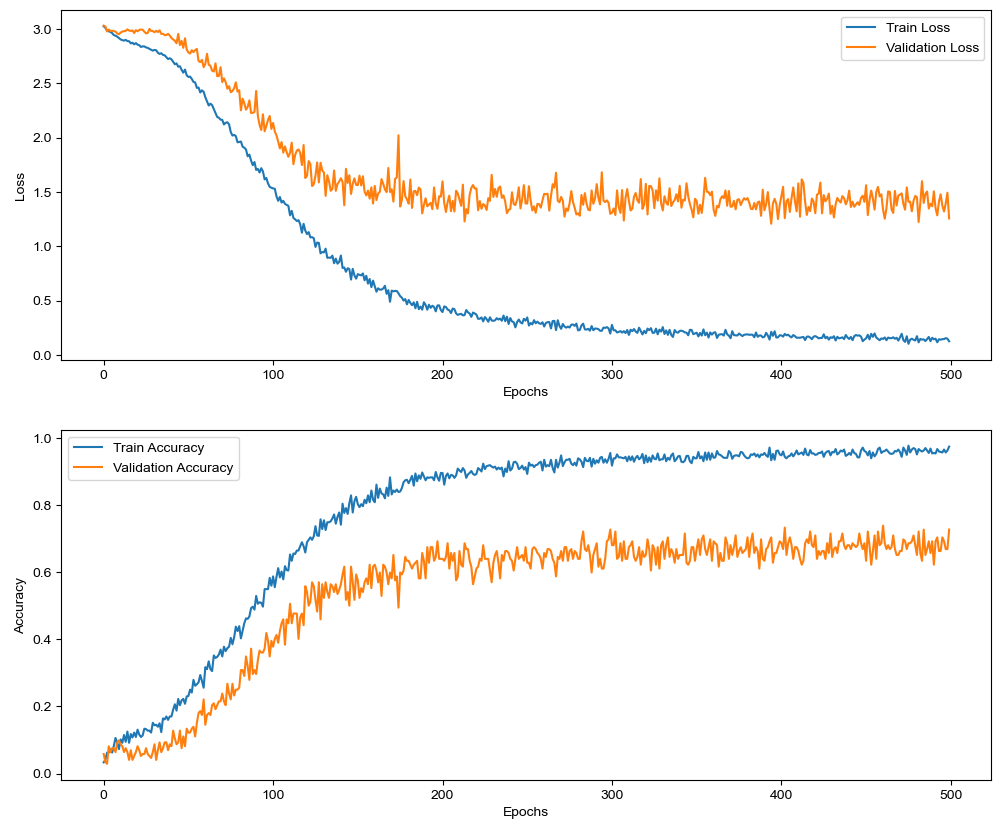

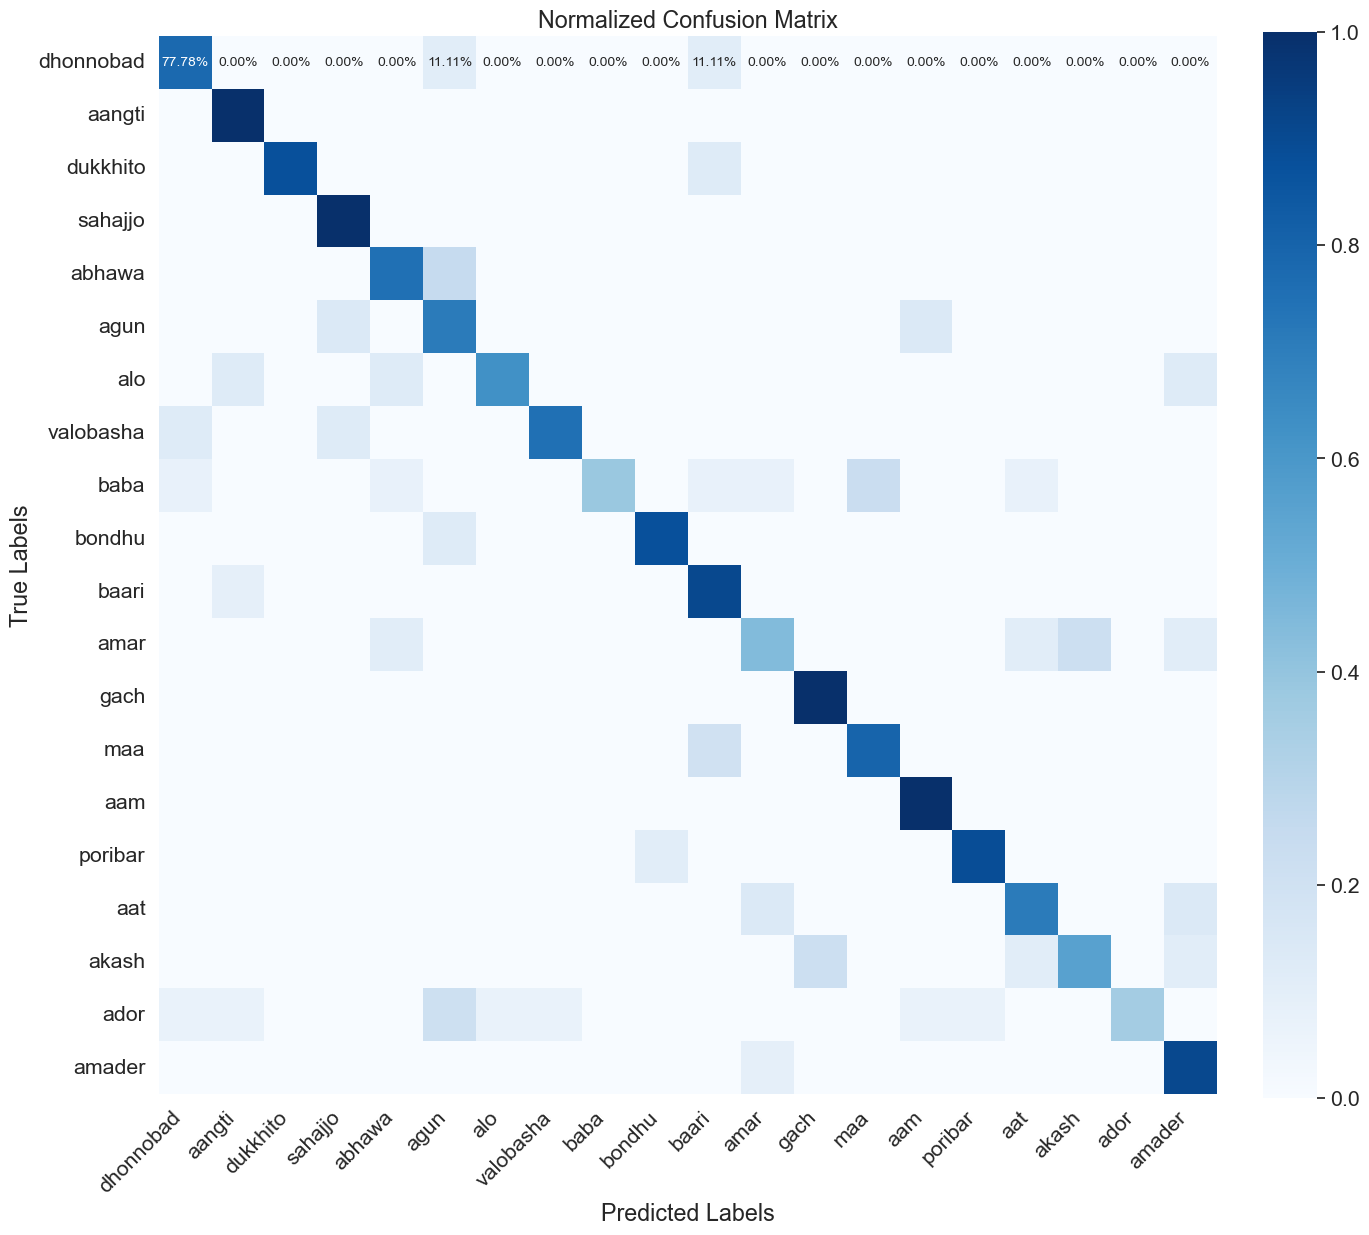

Final Evaluation on Validation Set:
Accuracy: 0.7267
Precision: 0.7280
Recall: 0.7358
F1-Score: 0.7156


In [8]:
import os
import torch
import torch.nn.functional as F
from torch.nn import init
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, random_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
# Assuming device is defined, e.g., device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_metrics(metrics, epoch, filepath):
    """ Save metrics in a CSV file for each epoch. """
    df = pd.DataFrame(metrics)
    df.to_csv(filepath, mode='a', header=not os.path.exists(filepath), index=False)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import normalize
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import os

def plot_confusion_matrix(predictions, labels, save_dir, class_names):
    """Plot a detailed confusion matrix with absolute values in each cell."""
    cm = confusion_matrix(labels, predictions)
    
    # Normalizing the confusion matrix by the number of samples in each actual class
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(14, 14))  # Adjusting figure size for better fit
    sns.set(font_scale=1.4)  # Scaling fonts to match the new figure size
    ax = sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Blues",
                     xticklabels=class_names, yticklabels=class_names,
                     square=True, annot_kws={"size": 10}, cbar_kws={"fraction": 0.046, "pad": 0.04})

    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')

    # Rotating the labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)

    plt.tight_layout()  # Ensuring nothing is cut off
    plt.savefig(os.path.join(save_dir, 'normalized_confusion_matrix.png'))
    plt.show()

# Example usage might go here if necessary





    
def plot_metrics(metrics):
    """ Plot training and validation loss and accuracy. """
    fig, axs = plt.subplots(2, figsize=(12, 10))
    axs[0].plot(metrics['train_loss'], label='Train Loss')
    axs[0].plot(metrics['val_loss'], label='Validation Loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[1].plot(metrics['train_accuracy'], label='Train Accuracy')
    axs[1].plot(metrics['val_accuracy'], label='Validation Accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    plt.savefig(os.path.join(save_dir, 'training_validation_metrics.png'))

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    total_prediction = 0
    correct_prediction = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, prediction = torch.max(outputs, 1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]
            all_preds.extend(prediction.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(dataloader)
    accuracy = correct_prediction / total_prediction
    class_report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'all_preds': all_preds,
        'all_labels': all_labels,
        'f1': class_report['macro avg']['f1-score'],
        'precision': class_report['macro avg']['precision'],
        'recall': class_report['macro avg']['recall']
    }

def training(model, train_dl, val_dl, num_epochs, device, class_names):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001, steps_per_epoch=len(train_dl), epochs=num_epochs, anneal_strategy='linear')

    best_val_accuracy = 0.0
    metrics = {
        'train_loss': [],
        'train_accuracy': [],
        'val_loss': [],
        'val_accuracy': [],
        'f1': [],
        'precision': [],
        'recall': []
    }
    start_time = time.time()  # Start time of the whole training process

    for epoch in range(num_epochs):
        epoch_start = time.time()  # Start time of the current epoch
        model.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for inputs, labels in train_dl:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).type(torch.float).sum().item()
            train_total += labels.size(0)

        train_loss /= len(train_dl)
        train_accuracy = train_correct / train_total
        eval_results = evaluate(model, val_dl, criterion)

        # Collect metrics for plotting and analysis
        metrics['train_loss'].append(train_loss)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['val_loss'].append(eval_results['loss'])
        metrics['val_accuracy'].append(eval_results['accuracy'])
        metrics['f1'].append(eval_results['f1'])
        metrics['precision'].append(eval_results['precision'])
        metrics['recall'].append(eval_results['recall'])

        # Save predictions and labels for the best model
        if eval_results['accuracy'] > best_val_accuracy:
            best_val_accuracy = eval_results['accuracy']
            model_path = os.path.join(save_dir, "audio_model_best.pth")
            torch.save(model.state_dict(), model_path)
            np.save(os.path.join(save_dir, 'predictions.npy'), np.array(eval_results['all_preds']))
            np.save(os.path.join(save_dir, 'labels.npy'), np.array(eval_results['all_labels']))

        epoch_time = time.time() - epoch_start  # Time taken for the current epoch
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {eval_results["loss"]:.4f}, Val Acc: {eval_results["accuracy"]:.4f}')
        print(f"Epoch Duration: {epoch_time:.2f} seconds")

    total_training_time = time.time() - start_time  # Total training time
    print(f"Total Training Time: {total_training_time:.2f} seconds")

    # Save the final metrics for further analysis if needed
    save_metrics(metrics, 'final', os.path.join(save_dir, 'final_metrics.csv'))

    # Load the best model for final evaluation
    model.load_state_dict(torch.load(model_path))
    plot_metrics(metrics)

    # Load predictions and labels for the confusion matrix
    predictions, labels = np.load(os.path.join(save_dir, 'predictions.npy')), np.load(os.path.join(save_dir, 'labels.npy'))
    plot_confusion_matrix(predictions, labels, save_dir, class_names)

    print("Final Evaluation on Validation Set:")
    print(f"Accuracy: {metrics['val_accuracy'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"F1-Score: {metrics['f1'][-1]:.4f}")

# Usage
num_epochs = 500  # Modify as necessary
training(myModel, train_dl, val_dl, num_epochs, device, class_names)



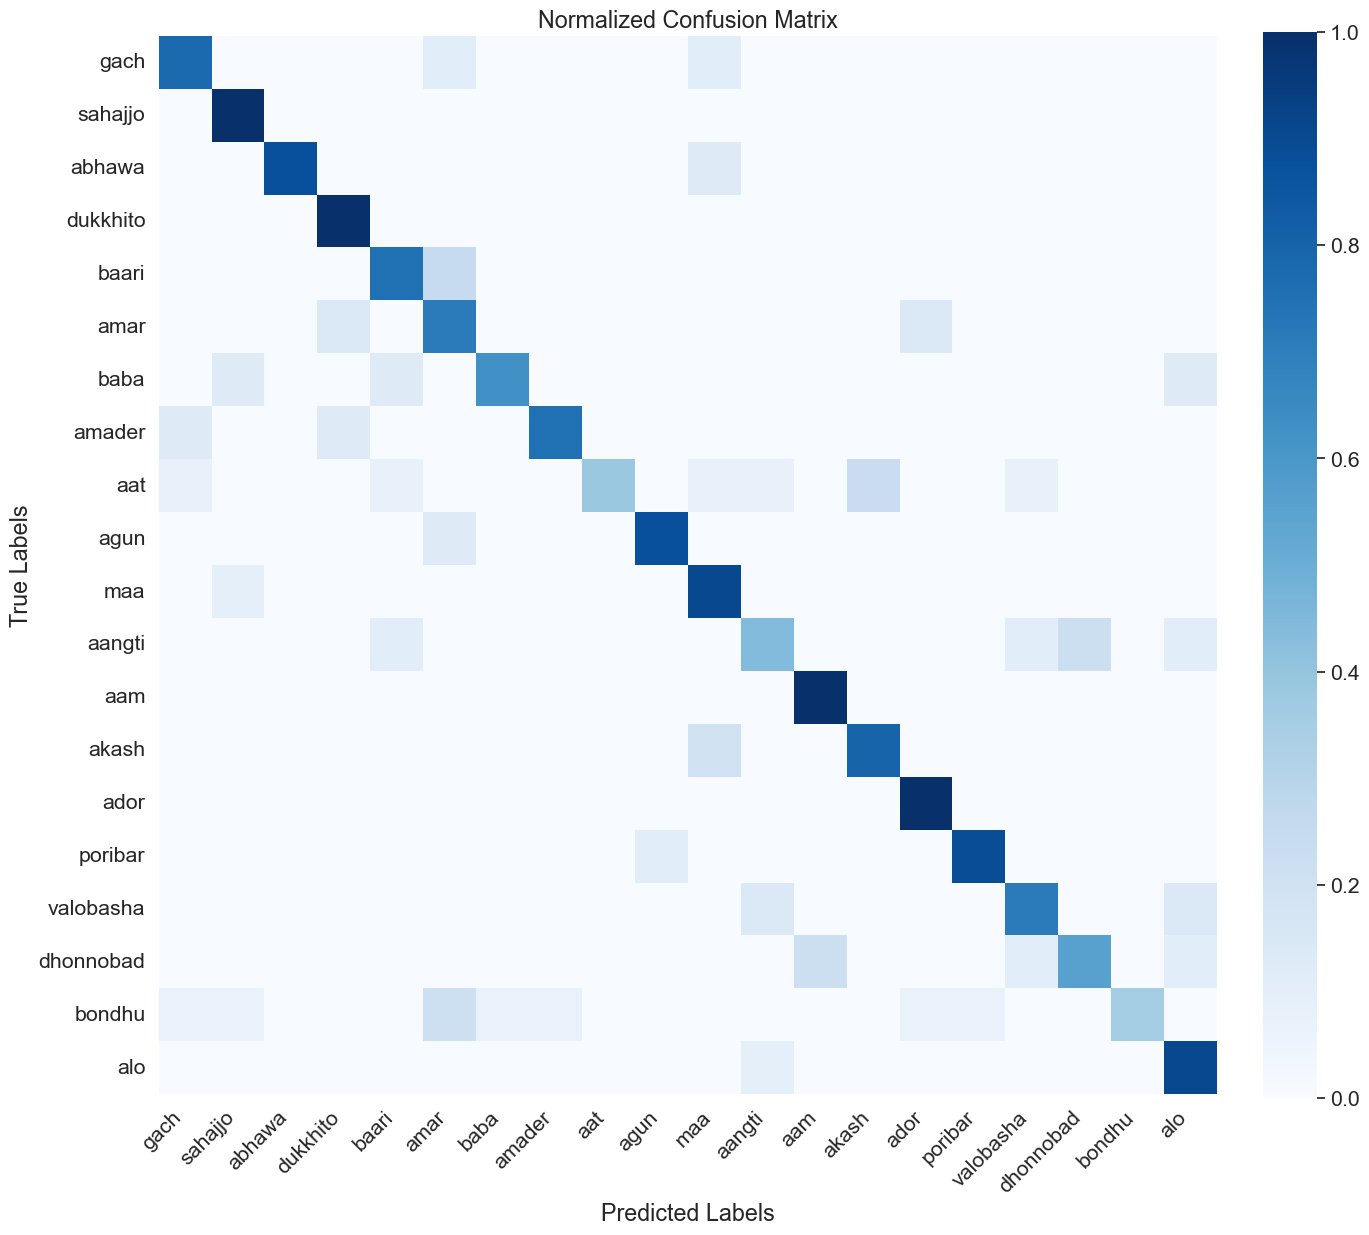

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os

def plot_confusion_matrix_from_files(predictions_file, labels_file, save_dir, class_names):
    """Plot a detailed confusion matrix using saved prediction and label files."""
    # Load predictions and labels
    predictions = np.load(predictions_file)
    labels = np.load(labels_file)

    # Generate the confusion matrix
    cm = confusion_matrix(labels, predictions)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(14, 14))
    sns.set(font_scale=1.4)  # Adjust font size for better readability
    heatmap = sns.heatmap(cm_normalized, annot=False, cmap="Blues",
                          xticklabels=class_names, yticklabels=class_names,
                          square=True, cbar_kws={"fraction": 0.046, "pad": 0.04})

    heatmap.set_title('Normalized Confusion Matrix')
    heatmap.set_xlabel('Predicted Labels')
    heatmap.set_ylabel('True Labels')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to make room for label rotations

    # Save the plot
    plt.savefig(os.path.join(save_dir, 'normalized_confusion_matrix.png'))
    plt.show()

# Example usage
#save_dir = 'your_save_directory'  # Specify your save directory
predictions_file = os.path.join(save_dir, 'predictions.npy')
labels_file = os.path.join(save_dir, 'labels.npy')
#class_names = ['class1', 'class2', 'class3']  # Replace with your actual class names

plot_confusion_matrix_from_files(predictions_file, labels_file, save_dir, class_names)
